## Rewrite
So what we really want is to minise all 4 independantly. I cant think of a good loss funciton for that so Im going to run 4 minimisations and pick the best.

In [7]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [8]:
layer = np.array([0,1,2,3,4,5,6,7])
wire = np.array([2,2,2,2,2,2,2,2])
tdc = np.array([9,190,59,121,129,51,198,17])
DIVIDER = 900

In [9]:
def conv_hit_to_coords(l : np.array, w : np.array):
    # if l is odd, add 0.5 to it
    x = l
    y = w+ 0.5*(l%2)
    return (x, y)

def get_basic_plot():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    for i in range(8):
        for j in range(8):
            x, y = conv_hit_to_coords(i,j)
            ax.plot(x, y, 'k.')

    x, y = conv_hit_to_coords(layer, wire)
    ax.plot(x, y, 'rx')
    ax.set(xlabel='Layer', ylabel='Wire',)
    return ax

def plot_TDC_circles(ax, v=1):
    
    for i in range(8):
        x, y = conv_hit_to_coords(layer[i], wire[i])
        ax.add_artist(plt.Circle((x,y), tdc[i] / DIVIDER * v, color='b', fill=False))
    
    return ax


In [10]:
# ax + bY + c = 0
class line:
    def __init__(self, a , b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def plot(self, ax, xmin, xmax):
        x = np.linspace(xmin, xmax, 100)
        y = (-self.a * x - self.c) / self.b
        ax.plot(x, y)
        return ax

class circle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    def plot(self, ax):
        ax.add_artist(plt.Circle((self.x, self.y), self.r, color='b', fill=False))
        return ax


def get_tangents_to_two_circles(c1, c2):
    ls = []

    # four solutions
    for i in [-1, 1]:
        for j in [-1, 1]:
            r1 = c1.r * i
            r2 = c2.r * j

            dr = r2 - r1

            x = c2.x - c1.x
            y = c2.y - c1.y

            z = x**2 + y**2
            d = np.sqrt( np.abs(z - dr**2) )

            a = (x * dr + y*d)/z
            b = (y * dr - x*d)/z
            c = r1 - c1.x * a - c1.y * b

            l = line(a, b, c)  
            ls.append(l) 

    return ls

# slightly faster than get_tangents to two circles
# (when written in c)
def get_nth_tangents_to_two_circles(c1, c2, n):
    
    if n == 0:
        i = 1
        j = 1
    
    elif n == 1:
        i = 1
        j = -1
    
    elif n== 2:
        i = -1
        j = 1
    
    else:
        i = -1
        j = -1

    # four solutions

    r1 = c1.r * i
    r2 = c2.r * j

    dr = r2 - r1

    x = c2.x - c1.x
    y = c2.y - c1.y

    z = x**2 + y**2
    d = np.sqrt( np.abs(z - dr**2) )

    a = (x * dr + y*d)/z
    b = (y * dr - x*d)/z
    c = r1 - c1.x * a - c1.y * b

    l = line(a, b, c)  

    return l

def circle_line_dist(l : line, v : float, c1_num : float, c2_num : float) -> float:
    # return the total distance to the line from the 6 other circles
    total_distance = 0.
    for i in range(8):
        if (i == c1_num) or (i == c2_num):
            ci_coords = conv_hit_to_coords(layer[i], wire[i])
            ci = circle(ci_coords[0], ci_coords[1], tdc[i] / DIVIDER * v)
            total_distance += np.abs(l.a * ci.x + l.b * ci.y + l.c) / np.sqrt(l.a**2 + l.b**2)

    return total_distance

def largest_circles():
    return np.argmax(tdc), np.argmax(tdc[tdc != np.max(tdc)])

In [11]:
# problem setup
i_c1, i_c2 = largest_circles()

c1_coords = conv_hit_to_coords(layer[i_c1], wire[i_c1])
c2_coords = conv_hit_to_coords(layer[i_c2], wire[i_c2])

def f(v, i):
    """
    v: velocity
    i: line tangent line number
    """

    # setup circles
    c1 = circle(c1_coords[0], c1_coords[1], tdc[i_c1] / DIVIDER * v)
    c2 = circle(c2_coords[0], c2_coords[1], tdc[i_c2] / DIVIDER * v)

    # get tangent
    l = get_nth_tangents_to_two_circles(c1, c2, i)

    return circle_line_dist(l, v, 0, 1)


In [13]:
res_arr = []
for i in range(4):
    res = minimize(f, x0=0.002, args=(i), method='Nelder-Mead')
    res_arr.append(res)
    print(i, ":", res.x)

0 : [-5.20417043e-18]
1 : [-2.0124]
2 : [2.0123]
3 : [-5.20417043e-18]


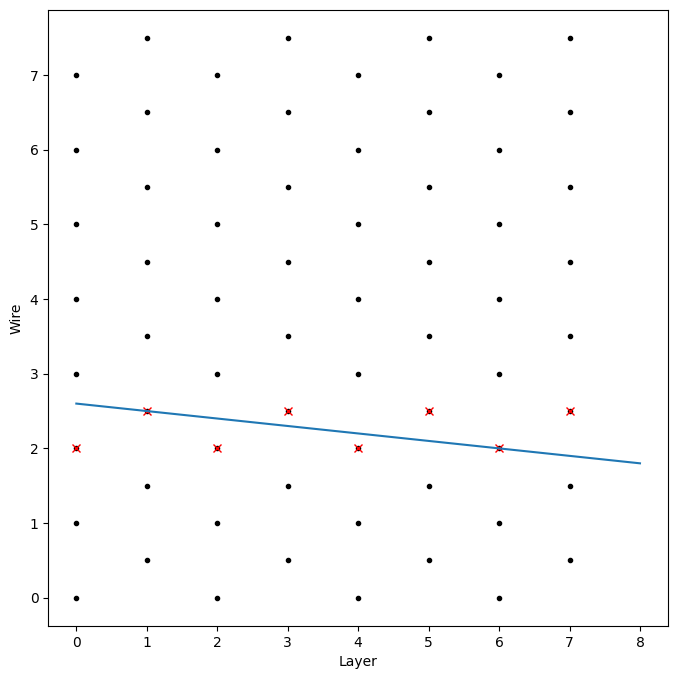

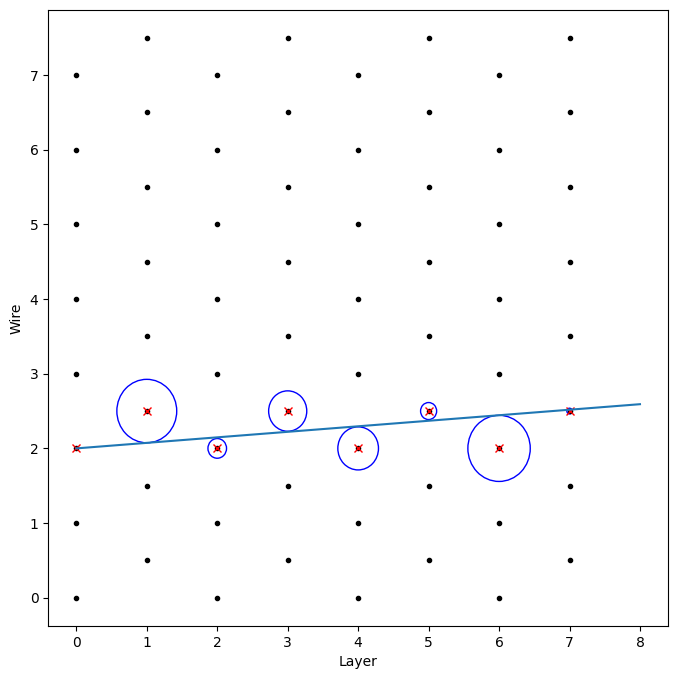

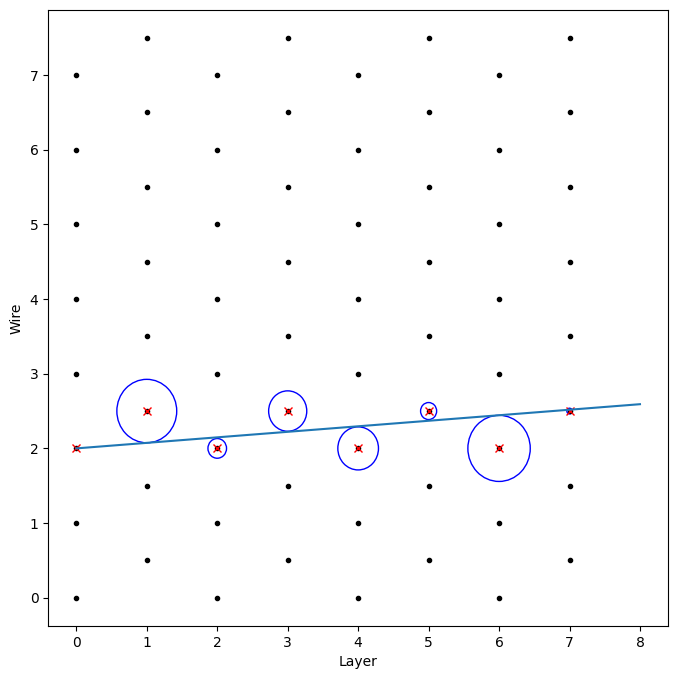

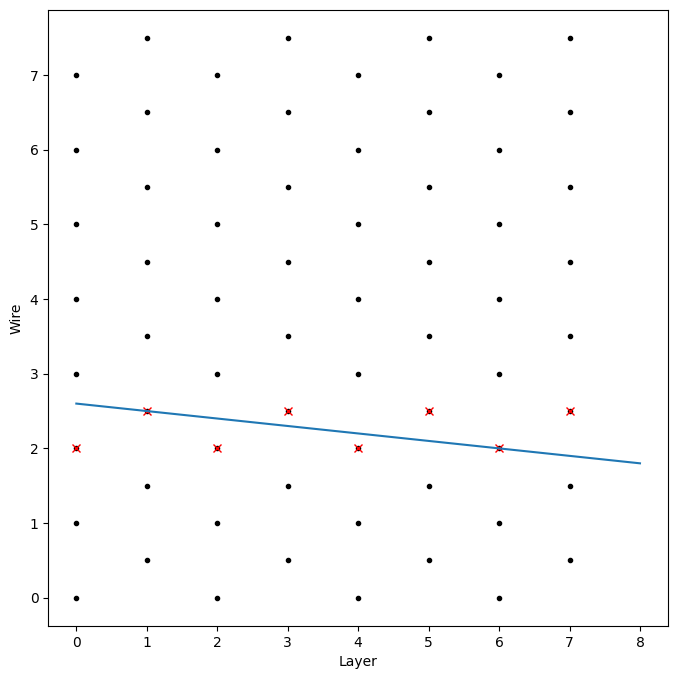

In [18]:
for i in range(4):
    v = res_arr[i].x
    ax = plot_TDC_circles(get_basic_plot(), v=v)
    i_c1, i_c2 = largest_circles()
    c1_coords = conv_hit_to_coords(layer[i_c1], wire[i_c1])
    c2_coords = conv_hit_to_coords(layer[i_c2], wire[i_c2])
    c1 = circle(c1_coords[0], c1_coords[1], tdc[i_c1] / DIVIDER * v)
    c2 = circle(c2_coords[0], c2_coords[1], tdc[i_c2] / DIVIDER * v)
    l = get_nth_tangents_to_two_circles(c1, c2, i)
    l.plot(ax, 0, 8)
    